### Example: Priors on function spaces
https://predictivesciencelab.github.io/data-analytics-se/lecture21/hands-on-21.html

In [26]:
import numpy as np

import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel

import matplotlib.pyplot as plt
import seaborn as sns

#### Squared exponential covariance function
GPytorch implements this covariance function as a composition of two kernels: RBFKernel and ScaleKernel.

plot kernel function

In [19]:
def plot_kernel(k):
    """Plot the covariance function."""
    fig, ax = plt.subplots()
    x = torch.linspace(-4, 4, 200)[:, None]
    zero = torch.zeros(1)[:, None]
    ks = k.forward(zero, x)
    ax.plot(x, ks.detach().T)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$k(0,x)$")
    sns.despine(trim=True)

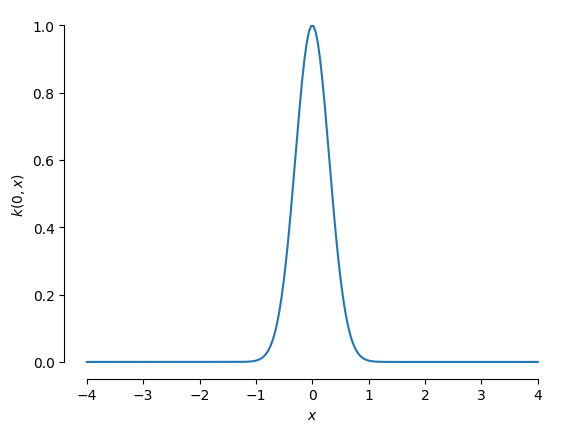

In [20]:
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.3
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the lengthscale ?

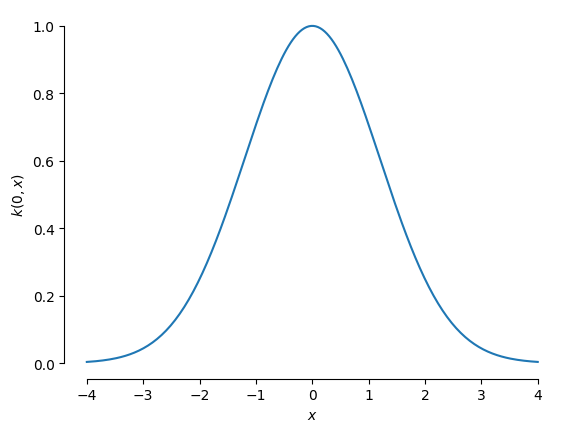

In [21]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the variance ?

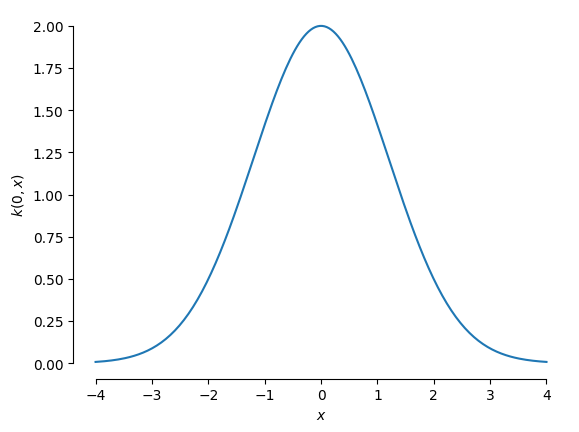

In [22]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 2.0
plot_kernel(k)

plot maternKernel

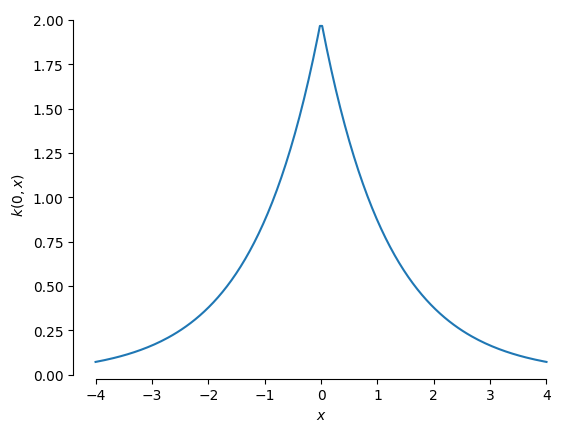

In [25]:
k1 = ScaleKernel(MaternKernel(nu=0.5))
k1.base_kernel.lengthscale = 1.2
k1.outputscale = 2.0
plot_kernel(k1)

#### Verify that the properties of covariance functions

covariance function must be positive definite

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
C:\Users\yangx\AppData\Local\Temp\ipykernel_11716\3859068568.py:16: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_{i}$")


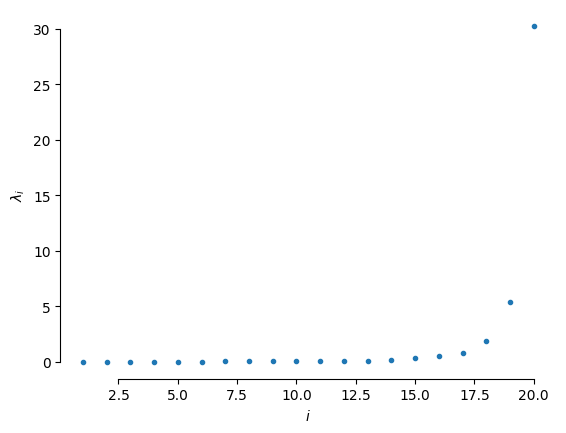

In [31]:
k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1

n = 20

X = torch.rand(n, 1)
K = k1.forward(X, X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = torch.linalg.eigh(K)

fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_{i}$")
sns.despine(trim=True)

sum of covariance functions

In [36]:
k1 = ScaleKernel(RBFKernel())
k1.base_kernel.lengthscale = 0.3
k1.outputscale = 1.0

k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1.5

k_new = k1 + k2

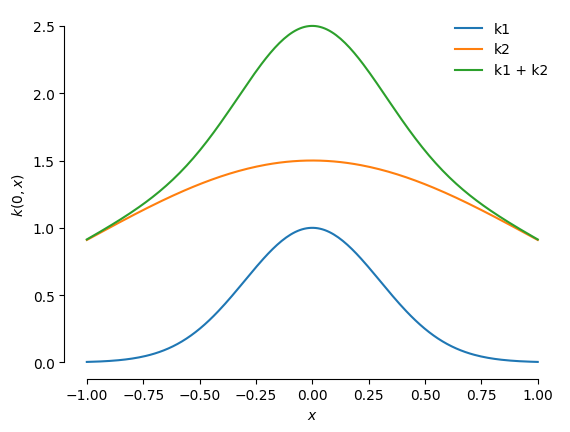

In [37]:
fig, ax = plt.subplots()
x = torch.linspace(-1, 1, 200)[:, None]
zero = torch.zeros(1)[:, None]
ks1 = k1.forward(zero, x)
ks2 = k2.forward(zero, x)
ks_new = k_new.forward(zero, x)
ax.plot(x, ks1.detach().T, label="k1")
ax.plot(x, ks2.detach().T, label="k2")
ax.plot(x, ks_new.detach().numpy().T, label="k1 + k2")
ax.set_xlabel("$x$")
ax.set_ylabel("$k(0,x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\yangx\AppData\Local\Temp\ipykernel_11716\3485106429.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_i$")


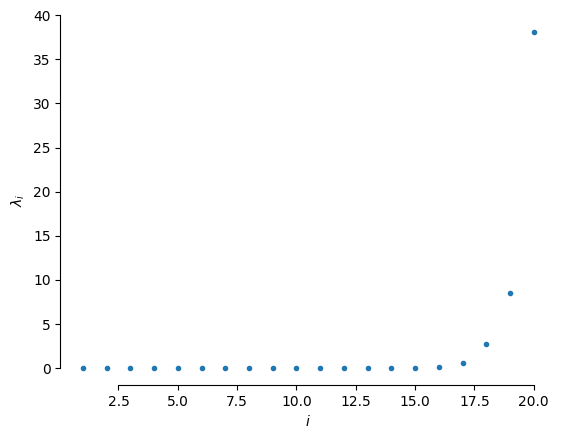

In [38]:
K_new = k_new.forward(X, X)
eig_val, eig_vec = torch.linalg.eigh(K_new)
fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_i$")
sns.despine(trim=True)

#### Sampling from a Gaussian process

we only need to know how to sample from the multivariate normal:

$$\mathbf{f}|\mathbf{x}_{1:n}\sim\mathcal{N}(\mathbf{m}(\mathbf{x}_{1:n}),\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}))$$

1. Compute the Cholesky of $\mathbf{L}$:
$$\mathbf{K}=\mathbf{L}\mathbf{L}^T$$
2. Draw n random samples $z$ independently from a standard normal.
3. Get one sample by:
$$\mathbf{f}=\mathbf{m}+\mathbf{Lz}.$$

In [54]:
def sample_functions(mean_func, kernel_func, num_samples=5, num_test=20, nugget=1e-5):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label="mean")
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5, label="sample" if i == 0 else None)
    plt.legend(loc="best", frameon=False)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_ylim(-3, 3)
    sns.despine(trim=True)

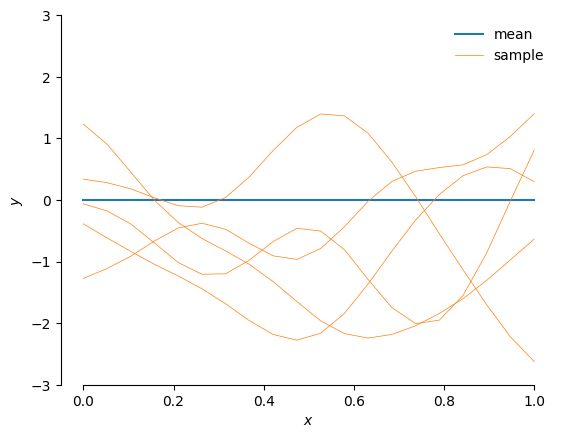

In [57]:
from gpytorch.means import ConstantMean, LinearMean

torch.manual_seed(123)

k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0

mean_func = ConstantMean()

sample_functions(mean_func, k)

effects of the lengthscale

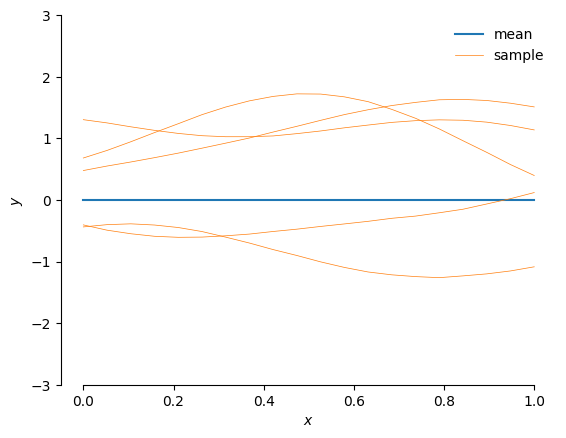

In [58]:
mean_func = ConstantMean()
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.5
k.outputscale = 1.0
sample_functions(mean_func, k)

##### effects of mean function
Let’s do a linear mean function:
$$m(x) = ax+b$$

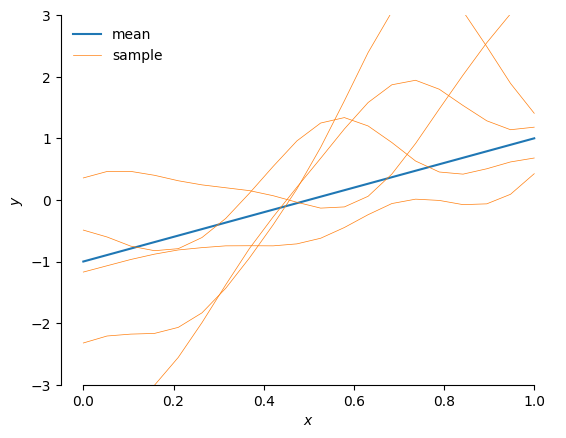

In [63]:
a = 2.0
b = -1.0
mean_func = LinearMean(input_size=1)
mean_func.weights = torch.nn.Parameter(torch.tensor([a]))
mean_func.bias = torch.nn.Parameter(torch.tensor([b]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

Let’s use a mean function that is not in the GPytorch library. We will the mean function:
$$m(x)=a\sin(\omega x)$$
We need to inherit from the `gpytorch.means.Mean` class and implement the `forward` method:

In [64]:
class MyMean(torch.nn.Module):
    """A custom mean function."""

    def __init__(self, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter("a", torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter("omega", torch.nn.Parameter(torch.randn(*batch_shape, 1)))

    def forward(self, x):
        return self.a * torch.sin(self.omega * x).squeeze(-1)

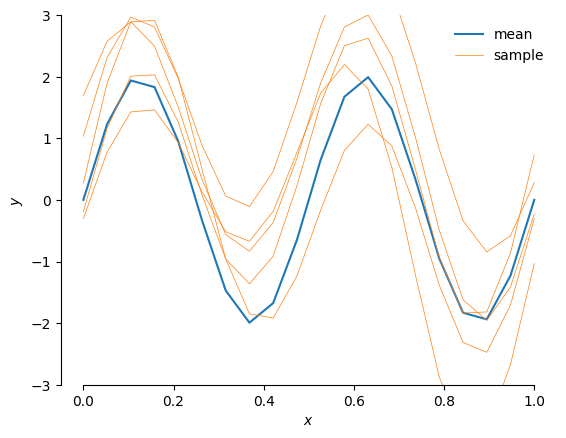

In [65]:
a = 2.0
omega = 2.0 * np.pi * 2.0
mean_func = MyMean()
mean_func.a = torch.nn.Parameter(torch.tensor([a]))
mean_func.omega = torch.nn.Parameter(torch.tensor([omega]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

#### The smoothness of the sampled functions is controlled by the smoothness of the covariance function

Let’s look at the samples of a function that is not infinitely differentiable. We will use the Matérn covariance function:
$$k(x,x')=\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)^{\nu}K_{\nu}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)$$

Samples from the Matérn covariance function are `cell(nu)-1` times differentiable.

Let `nu = 0.5`, we get continuous but nowhere differentiable samples.

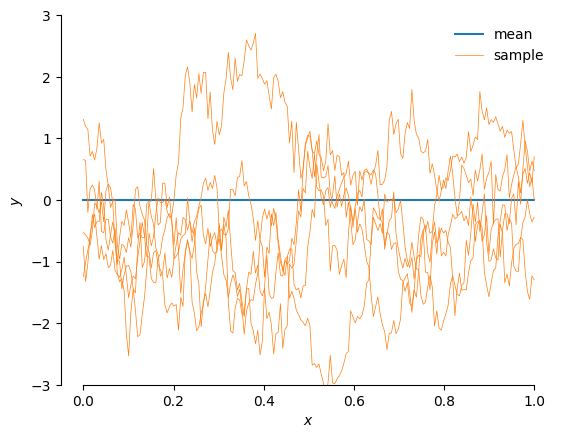

In [72]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=0.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

Compare to `mu=1.5`

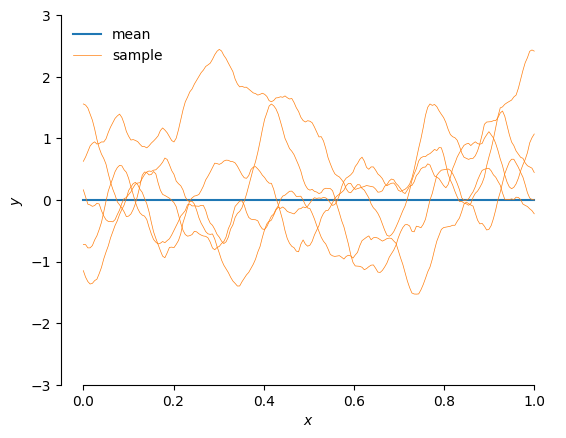

In [73]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=1.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

#### Modeling invariances

The covariance function can also be used to model invariances. One common invariance is translation invariance:

$$f(x+\delta)=f(x),\quad\forall x\in\mathbb{R},\delta\in\mathbb{R}.$$

One can show that if the covariance function is translation invariant, then samples are also translation invariant. An example of a translation invariant covariance function is the `PeriodicKernel`:

$$k(x,x')=\exp\left\{-\frac{2}{\ell}\sin^2\left(\frac{\pi}{p}|x-x'|\right)\right\}.$$

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


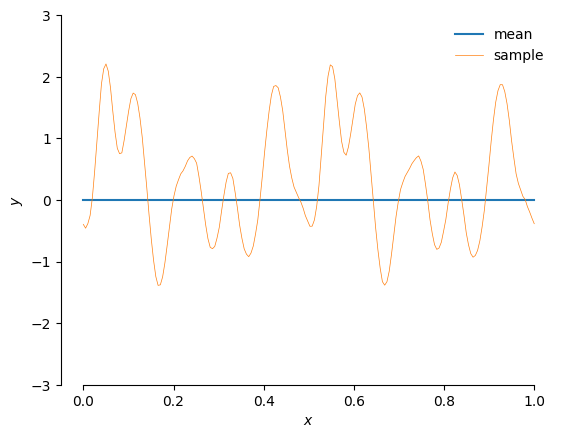

In [74]:
from gpytorch.kernels import PeriodicKernel

mean_func = ConstantMean()
k = ScaleKernel(PeriodicKernel())
print(k.base_kernel)
k.base_kernel.period_length = 0.5
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=1, num_test=200, nugget=1e-4)

#### Stationary and non-stationary covariance functions

So far we have only used stationary covariance functions. A covariance function is stationary if it depends only on the distance between the inputs:

$$k(x,x')=k(|x-x'|).$$

This means that the samples from that covariance function look similar everywhere.

Sometimes, we want to model functions that are not behaving in a similar manner for all inputs. For example, they may have more wiggles in some parts of the input space than others. A classic non-stationary covariance function is the `LinearKernel`:

$$k(x,x')=vxx'$$

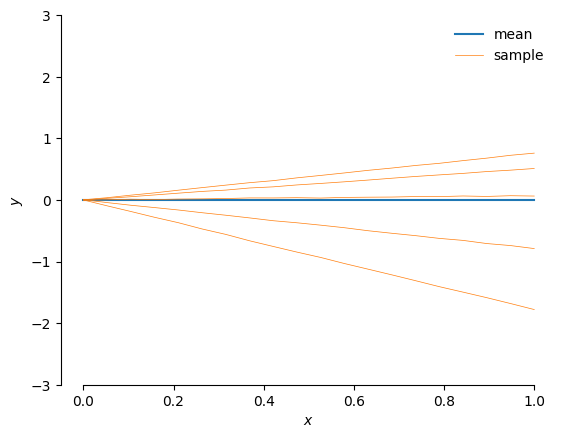

In [75]:
from gpytorch.kernels import LinearKernel

mean_func = ConstantMean()
k = LinearKernel()
k.outputscale = 1.0
sample_functions(mean_func, k)

Another classic non-stationary covariance function is the `PolynomialKernel`:

$$k(x,x')=(x^Tx'+c)^d$$

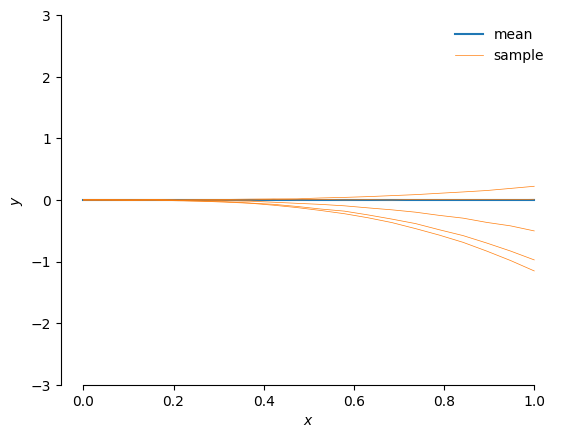

In [76]:
from gpytorch.kernels import PolynomialKernel

mean_func = ConstantMean()
k = ScaleKernel(PolynomialKernel(power=3))
k.base_kernel.offset = 0.0
k.outputscale = 1.0
sample_functions(mean_func, k)

#### Two (or more) length scales in samples

Suppose that we have a function that is the sum of two functions: one that varies slowly and one that varies quickly. How can we model this? We need to use two covariance functions: one with a small lengthscale and one with a large lengthscale. Then we need to add the two covariance functions together. Let’s see how this works.

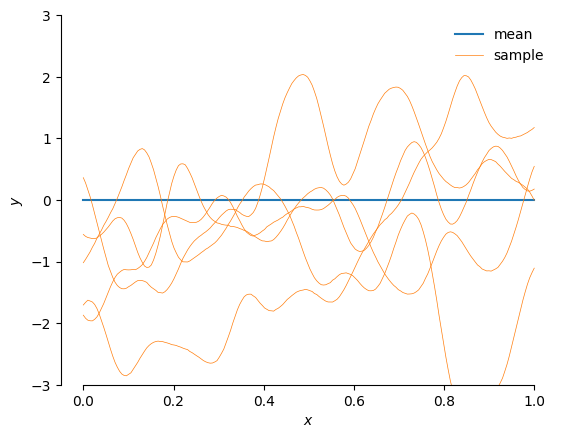

In [77]:
mean_func = ConstantMean()
kslow = ScaleKernel(RBFKernel())
kslow.base_kernel.lengthscale = 0.3
kslow.outputscale = 1.0
kfast = ScaleKernel(RBFKernel())
kfast.base_kernel.lengthscale = 0.05
kfast.outputscale = 0.4
k = kslow + kfast
sample_functions(mean_func, k, num_samples=5, num_test=200)